In [44]:
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from tqdm.auto import tqdm
from PIL import Image
from accelerate import Accelerator

import gc
gc.collect()
torch.cuda.empty_cache()

In [45]:
# accelerator = Accelerator()
# device = accelerator.device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_epochs = 30
batch_size = 30
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

cuda


In [46]:
trainset = datasets.ImageFolder('/kaggle/input/cvdlhw2/Dataset_OpenCvDl_Hw2_Q5/training_dataset/', transform = transform)
testset = datasets.ImageFolder('/kaggle/input/cvdlhw2/Dataset_OpenCvDl_Hw2_Q5/validation_dataset/', transform= transform)

In [47]:
train_loader = torch.utils.data.DataLoader(trainset
    , batch_size = batch_size
    , shuffle = True)
test_loader = torch.utils.data.DataLoader(testset
    , batch_size = batch_size
    , shuffle = True)

In [48]:
train_total_step = len(train_loader)
test_total_step = len(test_loader)
print(train_total_step, test_total_step)

540 60


torch.Size([30, 3, 224, 224])
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1])


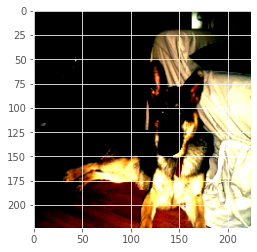

Label: 1


In [49]:
images, labels = next(iter(train_loader))
import matplotlib.pyplot as plt
print(images.shape)
print(labels)
plt.imshow(images[1].permute(1,2,0))
plt.show()
print(f"Label: {labels[1]}")

In [50]:
# from torchsummary import summary
model = torchvision.models.resnet50(pretrained = False)
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Linear(nr_filters, 1)

In [51]:
model = model.to(device)
# loss_function = torchvision.ops.sigmoid_focal_loss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                        lr = learning_rate, 
                        momentum=0.9,
                        weight_decay=5e-4)

# model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

In [52]:
H = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(num_epochs): # 
    # set the model in training mode
    model.train()
    total_train_loss = 0
    total_test_loss = 0
    train_correct = 0
    test_correct = 0
    # loop over the training set
    for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = model(x)
        y = y.unsqueeze(1).float()

        # 1. focal loss
#         loss = torchvision.ops.sigmoid_focal_loss(pred, y, alpha=0.4, gamma=1.0, reduction='mean')
        # 2. BSE loss
        m = nn.Sigmoid()
        criterion = nn.BCELoss()
        loss = criterion(m(pred), y)


        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        optimizer.zero_grad()
        loss.backward()
#         accelerator.backward(loss)
        optimizer.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        total_train_loss += float(loss)
        # print(loss)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        train_correct += (pred == y).type(torch.float).sum().item()
        # print("train_correct", train_correct)
        # print("train:", (pred == y).type(torch.float).sum().item()/batch_size)
  
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for i, (x, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
            # perform a forward pass and calculate the training loss
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            y = y.unsqueeze(1).float()
            # send the input to the device

            # 1. focal loss
#             loss = torchvision.ops.sigmoid_focal_loss(pred, y, alpha=0.4, gamma=1.0, reduction='mean')
            # 2. BSE loss
            m = nn.Sigmoid()
            criterion = nn.BCELoss()
            loss = criterion(m(pred), y)

            total_test_loss += float(loss)
            pred[pred >= 0.5] = 1
            pred[pred < 0.5] = 0
            test_correct += (pred == y).type(torch.float).sum().item()
            # print("test_correct", test_correct)
            # print("test:", (pred == y).type(torch.float).sum().item()/batch_size)

    # calculate the average training and validation loss
    avg_train_loss = total_train_loss / train_total_step
    avg_test_loss = total_test_loss / test_total_step

    # calculate the training and validation accuracy
    train_correct = train_correct / len(train_loader.dataset)
    test_correct = test_correct / len(test_loader.dataset)

    # update our training history
#     H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["train_loss"].append(avg_train_loss)
    H["train_acc"].append(train_correct)
#     H["test_loss"].append(avg_test_loss.cpu().detach().numpy())
    H["test_loss"].append(avg_test_loss)
    H["test_acc"].append(test_correct)

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, num_epochs))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avg_train_loss, train_correct))
    print("Test loss: {:.6f}, Test accuracy: {:.4f}\n".format(avg_test_loss, test_correct))

  0%|          | 0/540 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 1/30
Train loss: 0.668646, Train accuracy: 0.5744
Test loss: 0.618244, Test accuracy: 0.6106



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 2/30
Train loss: 0.649172, Train accuracy: 0.6035
Test loss: 0.870873, Test accuracy: 0.6822



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 3/30
Train loss: 0.639466, Train accuracy: 0.6231
Test loss: 0.620699, Test accuracy: 0.6922



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 4/30
Train loss: 0.616797, Train accuracy: 0.6405
Test loss: 0.595393, Test accuracy: 0.6167



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 5/30
Train loss: 0.600051, Train accuracy: 0.6578
Test loss: 0.626819, Test accuracy: 0.6117



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 6/30
Train loss: 0.580069, Train accuracy: 0.6751
Test loss: 0.617206, Test accuracy: 0.6394



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 7/30
Train loss: 0.573736, Train accuracy: 0.6852
Test loss: 0.532089, Test accuracy: 0.7078



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 8/30
Train loss: 0.551469, Train accuracy: 0.7010
Test loss: 0.535573, Test accuracy: 0.6778



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 9/30
Train loss: 0.532847, Train accuracy: 0.7197
Test loss: 0.499584, Test accuracy: 0.7428



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 10/30
Train loss: 0.493734, Train accuracy: 0.7444
Test loss: 0.452657, Test accuracy: 0.7656



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 11/30
Train loss: 0.466647, Train accuracy: 0.7626
Test loss: 0.534357, Test accuracy: 0.7889



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 12/30
Train loss: 0.447549, Train accuracy: 0.7794
Test loss: 0.443899, Test accuracy: 0.7856



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 13/30
Train loss: 0.429026, Train accuracy: 0.7938
Test loss: 0.524083, Test accuracy: 0.7900



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 14/30
Train loss: 0.404092, Train accuracy: 0.8038
Test loss: 0.406500, Test accuracy: 0.8206



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 15/30
Train loss: 0.374108, Train accuracy: 0.8212
Test loss: 0.443044, Test accuracy: 0.8033



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 16/30
Train loss: 0.356226, Train accuracy: 0.8329
Test loss: 0.411623, Test accuracy: 0.7889



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 17/30
Train loss: 0.331292, Train accuracy: 0.8449
Test loss: 0.479443, Test accuracy: 0.7478



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 18/30
Train loss: 0.305254, Train accuracy: 0.8607
Test loss: 0.376657, Test accuracy: 0.8244



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 19/30
Train loss: 0.300418, Train accuracy: 0.8671
Test loss: 0.644263, Test accuracy: 0.8217



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 20/30
Train loss: 0.269118, Train accuracy: 0.8816
Test loss: 0.400991, Test accuracy: 0.8367



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 21/30
Train loss: 0.250331, Train accuracy: 0.8894
Test loss: 1.115319, Test accuracy: 0.6328



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 22/30
Train loss: 0.218993, Train accuracy: 0.9054
Test loss: 0.499113, Test accuracy: 0.7939



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 23/30
Train loss: 0.195139, Train accuracy: 0.9188
Test loss: 0.855912, Test accuracy: 0.7072



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 24/30
Train loss: 0.176466, Train accuracy: 0.9256
Test loss: 0.883031, Test accuracy: 0.7450



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 25/30
Train loss: 0.163812, Train accuracy: 0.9309
Test loss: 0.435753, Test accuracy: 0.8317



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 26/30
Train loss: 0.141640, Train accuracy: 0.9430
Test loss: 0.908131, Test accuracy: 0.7200



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 27/30
Train loss: 0.138348, Train accuracy: 0.9431
Test loss: 0.571309, Test accuracy: 0.8261



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 28/30
Train loss: 0.113443, Train accuracy: 0.9545
Test loss: 0.673594, Test accuracy: 0.8400



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 29/30
Train loss: 0.102124, Train accuracy: 0.9604
Test loss: 0.658418, Test accuracy: 0.8311



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[INFO] EPOCH: 30/30
Train loss: 0.082691, Train accuracy: 0.9673
Test loss: 1.096193, Test accuracy: 0.7089



In [53]:
print(H["train_loss"])
print(H["train_acc"])
print(H["test_loss"])
print(H["test_acc"])

[0.6686460831099086, 0.6491724837709356, 0.6394656111244802, 0.6167969243945899, 0.6000506374019163, 0.5800686976975865, 0.573736396211165, 0.5514692663594528, 0.532847163743443, 0.4937337457029908, 0.46664739107644115, 0.44754853414164647, 0.42902607412801846, 0.4040921686148202, 0.3741075990928544, 0.35622571400470204, 0.33129156993495096, 0.3052542980760336, 0.3004175075502307, 0.26911799148139026, 0.2503305576396761, 0.21899315098783484, 0.19513910367257065, 0.17646587015026147, 0.16381212836648856, 0.14164007166055617, 0.13834791778483324, 0.11344320420606958, 0.10212422896918186, 0.08269097303100689]
[0.5744444444444444, 0.6034567901234568, 0.6231481481481481, 0.6404938271604939, 0.6577777777777778, 0.6750617283950617, 0.6851851851851852, 0.7010493827160493, 0.7196913580246913, 0.7443827160493827, 0.7625925925925926, 0.7794444444444445, 0.7938271604938272, 0.8037654320987654, 0.8212345679012346, 0.8329012345679012, 0.8448765432098766, 0.8607407407407407, 0.8670987654320987, 0.881

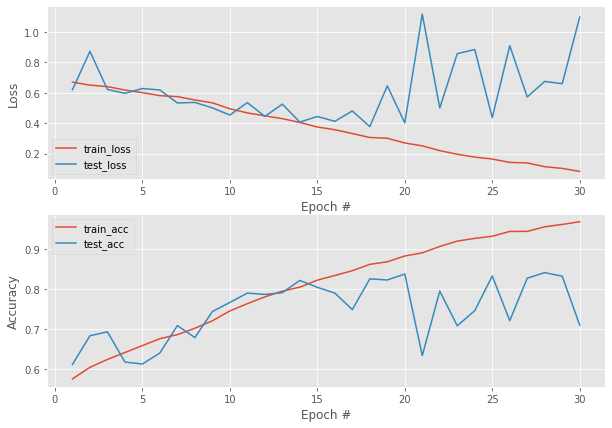

In [54]:
import matplotlib.pyplot as plt

# plot the training loss and accuracy
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2,2,(1,2))
plt.style.use("ggplot")

plt.plot(range(1, len(H["train_loss"]) + 1), H["train_loss"], label="train_loss")
plt.plot(range(1, len(H["test_loss"]) + 1), H["test_loss"], label="test_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

fig.add_subplot(2,2,(3,4))
plt.plot(range(1, len(H["train_acc"]) + 1), H["train_acc"], label="train_acc")
plt.plot(range(1, len(H["test_acc"]) + 1), H["test_acc"], label="test_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")

plt.savefig('batch30_epoch30_BCE.png')
plt.show()

In [55]:
torch.save(model, 'batch30_epoch30_BCE.pt')

In [56]:
model = torch.load('./batch30_epoch30_BCE.pt')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [57]:
img = Image.open('/kaggle/input/cvdlhw2/Dataset_OpenCvDl_Hw2_Q5/inference_dataset/Cat/190315.jpg').convert('RGB').resize((224,224), Image.ANTIALIAS)
tfms = transforms.Compose([
        # transforms.Resize(224,224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# unsqueeze provides the batch dimension
img_tensor = tfms(img).to(device).unsqueeze(0)

output = model(img_tensor)
m = nn.Sigmoid()
output = m(output)

# # to binarize the output since I had only 1 class
output = (output.squeeze().cpu().detach().numpy())
print(output)

cor_class_list = ['Cat', 'Dog']
label = 'Cat' if output < 0.5 else 'Dog'
print(label)

6.128285e-05
Cat


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """Entry point for launching an IPython kernel.
